<center><img src='../img/lake_office.jpg' alt='Lake Michigan Office' height='300'/></center>

# Predictions Evaluation: Heart Disease

## Introduction

In this notebook, we will optimize the models evaluated in [nb02_models_evaluation.ipynb](./nb02_models_evaluation.ipynb). We will focus on optimizing [LGBMClassifier](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html) and [CatBoostClassifier](https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier) because they provided promising results during our initial validation analysis in terms of **recall** and performance.

## Feature Selection

As previously showed the most promising results were achieved when using Feature Elimination with Cross-Validation (RFECV) with the expert knowledge from a cardiologist.

## Fine-Tuning and Pipeline Opmitization

The primary goal is to minimize false negatives by **optimizing the recall metric**, which is critical in medical applications. 

To achieve this, we will conduct an optimal hyperparameter tuning process using GridSearch and cross-validation on the test set.

We will also implement pipelines to streamline the workflow, enabling easier integration of the model into production scripts. This approach ensures that the model is fully optimized and ready for implementation, making deployment in real-world applications straightforward and efficient.



## Libraries

In [1]:
import pickle
from time import time

import pandas as pd
import seaborn as sns
from catboost import CatBoostClassifier
from catboost.utils import get_gpu_device_count
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from lightgbm import LGBMClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,
                             confusion_matrix, roc_auc_score)
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.utils import shuffle

# modern style
sns.set_theme(style='dark', palette='bright')

## Target and Features Declaration

In [2]:
# classification target
TARGET = 'HadHeartAttack'

# categorical features selected by RFECV and cardiologist expertise
CAT_FEATURES = [
    'GeneralHealth',
    'RemovedTeeth',
    'HadDiabetes', 
    'SmokerStatus',
    'AgeCategory',
    'HadAngina',
    'HadStroke',
    'HadCOPD',
    'DeafOrHardOfHearing',
    'DifficultyWalking',
    'ChestScan',   
    'AlcoholDrinkers',
    'Sex',  
    'PhysicalActivities'
]

# numerical features selected by RFECV and cardiologist expertise
NUM_FEATURES = [    
    'SleepHours',
    'WeightInKilograms',
    'BMI'
]

# features selected by RFECV and cardiologist expertise
FEATURES = CAT_FEATURES + NUM_FEATURES

## Load train-test sets

We load the training file to train our models using cross-validation and a separate test set for final validation. 


In [3]:
# for reproducibility
random_state = 42

# load dataset and train-validation-test split
train_set = pd.read_csv('../data/processed/heart_disease_train.csv')
test_set = pd.read_csv('../data/processed/heart_disease_test.csv')

Feature selection will be managed directly within the pipeline, ensuring a streamlined and consistent approach to selecting the most relevant features throughout the training and evaluation process.

In [4]:
# X, y splits
X_train = train_set.drop(columns=[TARGET])
y_train = train_set[TARGET]

X_test = test_set.drop(columns=[TARGET])
y_test = test_set[TARGET]

In [5]:
# dtype: object and float64
X_train[FEATURES].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196817 entries, 0 to 196816
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   GeneralHealth        196817 non-null  object 
 1   RemovedTeeth         196817 non-null  object 
 2   HadDiabetes          196817 non-null  object 
 3   SmokerStatus         196817 non-null  object 
 4   AgeCategory          196817 non-null  object 
 5   HadAngina            196817 non-null  object 
 6   HadStroke            196817 non-null  object 
 7   HadCOPD              196817 non-null  object 
 8   DeafOrHardOfHearing  196817 non-null  object 
 9   DifficultyWalking    196817 non-null  object 
 10  ChestScan            196817 non-null  object 
 11  AlcoholDrinkers      196817 non-null  object 
 12  Sex                  196817 non-null  object 
 13  PhysicalActivities   196817 non-null  object 
 14  SleepHours           196817 non-null  float64
 15  WeightInKilograms

LabelEncoder is particularly useful because it sorts the labels alphabetically. For the target variable, "No" will be encoded as 0, and "Yes" will be encoded as 1, and these represent the cases we aim to detect.

In [6]:
# LabelEncoder applied because encoder mapping has got alphabetical order
le = LabelEncoder()

# numpy.ndarrays
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# print the mapping of labels to encoded values
mapping = dict(zip(le.classes_, range(len(le.classes_))))
print("Label encoding mapping:", mapping)

# distribution with encoded values
display(pd.Series(y_train_encoded).value_counts())

Label encoding mapping: {'No': 0, 'Yes': 1}


0    186069
1     10748
Name: count, dtype: int64

## LGBMClassifier

First, we will train the LGBMClassifier model. 

### Fitting

We will optimize its hyperparameters using GridSearchCV, focusing on improving recall to minimize false negatives. The training process will involve cross-validation to ensure the model's generalization ability.

In [ ]:
# NOTICE!           NOTICE!           NOTICE!           NOTICE!
# I created the ShuffleTransformer class to shuffle the data; however, 
# I ultimately decided not to use it here, as cross-validation already 
# shuffles the data during training. Nonetheless, this class could be 
# useful for future projects where data shuffling is required before 
# model training without cross-validation.

class ShuffleTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, random_state=None):
        """
        Initializes the shuffle transformer.
        
        Parameters
        ----------
        random_state (int or None, optional): Controls randomness. 
            If set, the shuffle will be reproducible.
        """
        self.random_state = random_state

    def fit(self, X, y=None):
        """
        No fitting necessary, just return the object.
        This method is needed to be compatible with scikit-learn pipeline.
        """
        return self

    def transform(self, X, y=None):
        """
        This method is required for compatibility with sklearn transformers.
        It does nothing in `transform` step and just returns X as is.
        """
        return X

    def resample(self, X, y):
        """
        Perform shuffle on X and y with random_state if provided.
        This method is used for resampling and is compatible with imbalanced-learn.
        """
        X_shuffled, y_shuffled = shuffle(X, y, random_state=self.random_state)
        return X_shuffled, y_shuffled

In [ ]:
# DEPRECATED!        DEPRECATED!        DEPRECATED!        DEPRECATED!
# class ImputeAndConvertToCategory(BaseEstimator, TransformerMixin):
#     def __init__(self, cat_features):
#         self.cat_features = cat_features
#         self.imputer = SimpleImputer(strategy='most_frequent')  # Imputación de datos faltantes

#     def fit(self, X, y=None):
#         self.imputer.fit(X[self.cat_features], y)
#         return self

#     def transform(self, X):
#         X_copy = X.copy()
#         X_copy[self.cat_features] = self.imputer.transform(X_copy[self.cat_features])
        
#         X_copy[self.cat_features] = X_copy[self.cat_features].apply(lambda col: col.astype('category'))
#         return X_copy

In [9]:
# features preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')), 
            ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
            ]), CAT_FEATURES),
        ('num', SimpleImputer(strategy='median'), NUM_FEATURES)
        ],
    remainder='drop'
)

# pipeline: balance classes, preprocessing, classification model
pipeline = Pipeline([
    ('undersampling', RandomUnderSampler(random_state=random_state)),
    # ('shuffle', ShuffleTransformer(random_state=random_state)),
    ('preprocessor', preprocessor),
    ('model', LGBMClassifier())
])

# grid parameters
param_grid = {
    'model__objective': ['binary'],
    'model__boosting_type': ['gbdt'],
    'model__random_state': [random_state],
    'model__num_leaves': [31, 45, 60],
    'model__max_depth': [4, 7, 10],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__n_estimators': [100, 200, 400],
    'model__min_child_samples': [20, 40],
    'model__subsample': [0.8, 1.0],
    'model__colsample_bytree': [0.8, 1.0]
}

# set up GridSearchCV kwargs, using StratifiedKFold
kwargs = {
    'cv': StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state),
    'scoring': 'recall',
    'n_jobs': -5,
    'verbose': 1 
}

# hyperparameters tuning
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    **kwargs
)

# fit
time_init = time()
grid_search.fit(X_train, y_train_encoded)
fit_time = (time() - time_init) / 60    # minutes
print(f'\nFitting time: {round(fit_time, 2)} minutes.')

# results
print('Best hyperparameters:', grid_search.best_params_)
print('Best recall score:', grid_search.best_score_)

# save best estimator model to a pickle file
with open(f'../models/nb03_lgbm_model.pkl', 'wb') as file:
    pickle.dump(grid_search.best_estimator_, file)


Fitting 5 folds for each of 648 candidates, totalling 3240 fits
[LightGBM] [Info] Number of positive: 10748, number of negative: 10748
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001273 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 565
[LightGBM] [Info] Number of data points in the train set: 21496, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

Fitting time: 25.16 minutes.
Best hyperparameters: {'model__boosting_type': 'gbdt', 'model__colsample_bytree': 0.8, 'model__learning_rate': 0.01, 'model__max_depth': 10, 'model__min_child_samples': 20, 'model__n_estimators': 100, 'model__num_leaves': 60, 'model__objective': 'binary', 'model__random_state': 42, 'model__subsample': 0.8}
Best recall score: 0.8018221130433842


### Test Validation

After tuning the model, we evaluate its performance on the test set. This approach will help us understand how well the model performs with unseen data, ensuring that it is robust and ready for deployment.

Validation Set Metrics for LGBMClassifier tuned:
ROC AUC Score: 0.8837

Confusion Matrix:
[[37110  9408]
 [  554  2133]]

Heart Attack Classification Report:
              precision    recall  f1-score   support

          No       0.99      0.80      0.88     46518
         Yes       0.18      0.79      0.30      2687

    accuracy                           0.80     49205
   macro avg       0.59      0.80      0.59     49205
weighted avg       0.94      0.80      0.85     49205



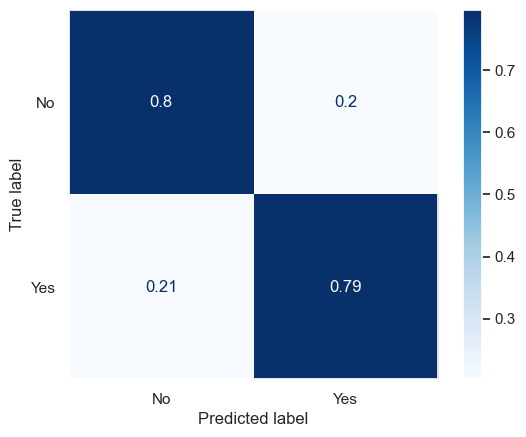

In [10]:
# load the best model from a pickle file
with open('../models/nb03_lgbm_model.pkl', 'rb') as file:
    model = pickle.load(file)
    
# LGBMClassifier model pipeline. X_test predictions
X = X_test
y_encoded = y_test_encoded
y_pred = model.predict(X)

# ROC AUC score
roc_auc = roc_auc_score(y_encoded, model.predict_proba(X)[:, 1])
print(f'Validation Set Metrics for LGBMClassifier tuned:')
print(f'ROC AUC Score: {roc_auc:.4f}', end='\n\n')

# confusion matrix
conf_matrix = confusion_matrix(y_encoded, y_pred)
print('Confusion Matrix:')
print(conf_matrix, end='\n\n')

# Generate and display the classification report
print('Heart Attack Classification Report:')
print(classification_report(y_encoded, y_pred, target_names=['No', 'Yes']))

# Generate and display the confusion matrix
conf_matrix = confusion_matrix(y_encoded, y_pred, normalize='true')
ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                       display_labels=['No', 'Yes']).plot(cmap='Blues');

## CatBoostClassifier

We will train the CatBoost model. 

### Fitting

Note that CatBoost can be resource-intensive, especially without GPU acceleration. 

**Modify the configuration as needed** if you are not running this in an environment like Colab or do not have access to a GPU. In such cases, setting task_type='CPU' may help maintain efficiency, though training may take longer.

In [11]:
# display if any GPU is available
print(f'{get_gpu_device_count()} GPU devices available.')

1 GPU devices available.


In [12]:
# GPU device ID == 0
!nvidia-smi

Wed Nov 13 00:28:13 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.90                 Driver Version: 565.90         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   58C    P3             10W /   35W |       0MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [13]:
# convert categorical feature names to a list of their column indices in the dataset
cat_features_index = [X_train[FEATURES].columns.get_loc(feature) for feature in CAT_FEATURES]
print('Categorical features indexes:',  cat_features_index)

Categorical features indexes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


In [14]:
# pipeline: balance classes, features preprocessing and CatBoost classification model
pipeline = Pipeline([
    ('undersampling', RandomUnderSampler(random_state=random_state)),
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('cat', SimpleImputer(strategy='most_frequent'), CAT_FEATURES),
            ('num', SimpleImputer(strategy='median'), NUM_FEATURES)
        ],
        remainder='drop'
    )),
    ('model', CatBoostClassifier(cat_features=cat_features_index,
                                #  task_type='GPU',
                                #  devices='0',
                                 random_seed=random_state))
])

# grid parameters
param_grid = {
    'model__iterations': [100, 200],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__depth': [7, 10],
    'model__l2_leaf_reg': [1, 5, 7],
    'model__bagging_temperature': [0.0, 1.0]
}

# set up GridSearchCV kwargs, using StratifiedKFold
kwargs = {
    'cv': StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state),
    'scoring': 'recall',
    'n_jobs': -5,
    'verbose': 1 
}

# hyperparameters tuning
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    **kwargs
)

# fit
time_init = time()
grid_search.fit(X_train, y_train_encoded)
fit_time = (time() - time_init) / 60    # minutes
print(f'\nFitting time: {round(fit_time, 1)} minutes.')

# results
print('Best hyperparameters:', grid_search.best_params_)
print('Best recall score:', grid_search.best_score_)

# save best estimator model to a pickle file
with open(f'../models/nb03_cat_model.pkl', 'wb') as file:
    pickle.dump(grid_search.best_estimator_, file)


Fitting 5 folds for each of 72 candidates, totalling 360 fits
0:	learn: 0.6633059	total: 234ms	remaining: 46.6s
1:	learn: 0.6375122	total: 291ms	remaining: 28.8s
2:	learn: 0.6149900	total: 395ms	remaining: 25.9s
3:	learn: 0.5920333	total: 487ms	remaining: 23.9s
4:	learn: 0.5718699	total: 572ms	remaining: 22.3s
5:	learn: 0.5540014	total: 635ms	remaining: 20.5s
6:	learn: 0.5381645	total: 726ms	remaining: 20s
7:	learn: 0.5241474	total: 815ms	remaining: 19.6s
8:	learn: 0.5112823	total: 898ms	remaining: 19.1s
9:	learn: 0.4994711	total: 975ms	remaining: 18.5s
10:	learn: 0.4905986	total: 1.05s	remaining: 18.1s
11:	learn: 0.4830005	total: 1.09s	remaining: 17s
12:	learn: 0.4750858	total: 1.17s	remaining: 16.8s
13:	learn: 0.4676262	total: 1.25s	remaining: 16.6s
14:	learn: 0.4614658	total: 1.33s	remaining: 16.4s
15:	learn: 0.4558809	total: 1.4s	remaining: 16.1s
16:	learn: 0.4511398	total: 1.47s	remaining: 15.9s
17:	learn: 0.4467566	total: 1.56s	remaining: 15.8s
18:	learn: 0.4421662	total: 1.65s	r

### Test Validation

As previously, we valuate its performance on the test set.

Validation Set Metrics for CatBoostClassifier tuned:
ROC AUC Score: 0.8846

Confusion Matrix:
[[37475  9043]
 [  563  2124]]

Heart Attack Classification Report:
              precision    recall  f1-score   support

          No       0.99      0.81      0.89     46518
         Yes       0.19      0.79      0.31      2687

    accuracy                           0.80     49205
   macro avg       0.59      0.80      0.60     49205
weighted avg       0.94      0.80      0.85     49205



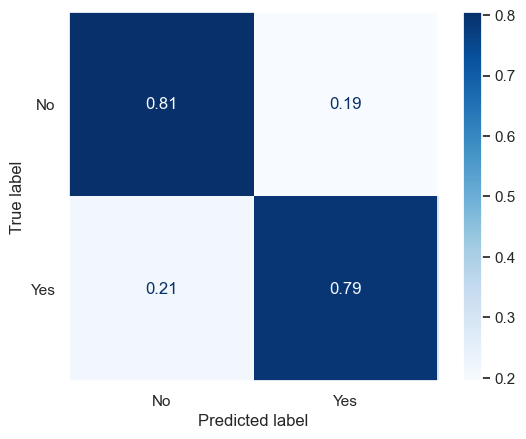

In [15]:
# load the best model from a pickle file
with open('../models/nb03_cat_model.pkl', 'rb') as file:
    model = pickle.load(file)
    
# CatBoostClassifier model pipeline. X_test predictions
X = X_test
y_encoded = y_test_encoded
y_pred = model.predict(X)

# ROC AUC score
roc_auc = roc_auc_score(y_encoded, model.predict_proba(X)[:, 1])
print(f'Validation Set Metrics for CatBoostClassifier tuned:')
print(f'ROC AUC Score: {roc_auc:.4f}', end='\n\n')

# confusion matrix
conf_matrix = confusion_matrix(y_encoded, y_pred)
print('Confusion Matrix:')
print(conf_matrix, end='\n\n')

# Generate and display the classification report
print('Heart Attack Classification Report:')
print(classification_report(y_encoded, y_pred, target_names=['No', 'Yes']))

# Generate and display the confusion matrix
conf_matrix = confusion_matrix(y_encoded, y_pred, normalize='true')
ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                       display_labels=['No', 'Yes']).plot(cmap='Blues');

## Conclusions

In this project, we aimed to detect heart attacks using ML models. We evaluated and optimized two advanced models: LightGBM and CatBoost. Both models were tuned for performance with a focus on improving **recall**, given the importance of minimizing false negatives in predicting heart attacks.

In real-world healthcare, both True Positives (TP) and True Negatives (TN) are crucial:

- True Positives (TP): Correctly detecting heart attacks is critical for timely intervention, potentially saving lives.
- True Negatives (TN): Correctly identifying healthy patients is equally important, as false positives can cause unnecessary emotional distress, anxiety, and invasive tests.

Both models showed promising results with very similar performance metrics. The LightGBM model demonstrated efficiency with its gradient boosting framework, while CatBoost provided competitive results due to its handling of categorical features and GPU acceleration posibilities.

The similarity in performance suggests that either model could be effectively used for heart attack detection, depending on the computational resources available. 

Future work could explore further refinements in feature engineering, model ensembling, or the application of other advanced algorithms to further improve predictive accuracy.


